# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 9 за первые три

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
seed = 1000-7
np.random.seed(seed)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



In [ ]:
# Мы выбрали равномерное распределение, теперь решение зависит
# от того, какой порог мы выберем. Порог распределен от 0 до 1,
# поэтому вероятность отнесения к каждому из классов равна 1/2

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


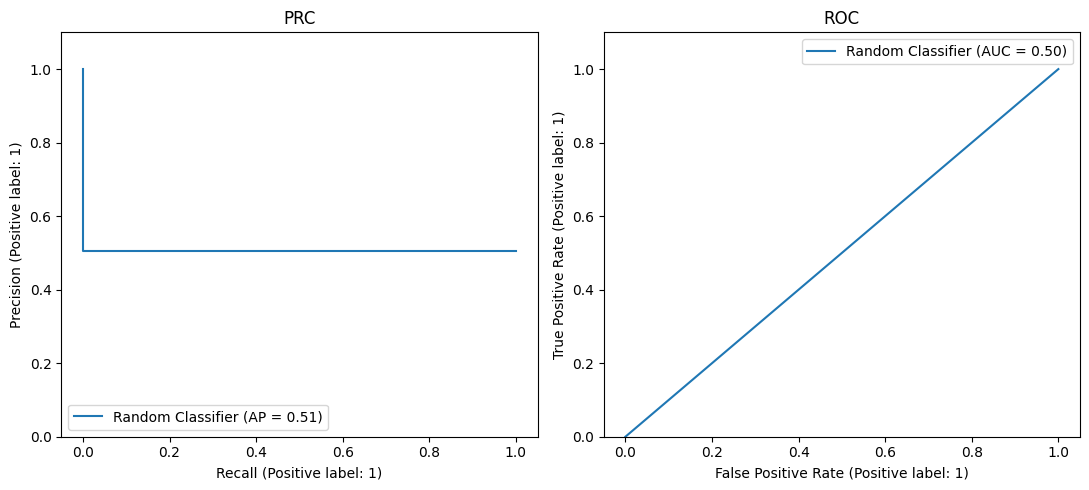

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import SVC

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM metrics
AUC-PR: 0.83369
AUC-ROC: 0.77514


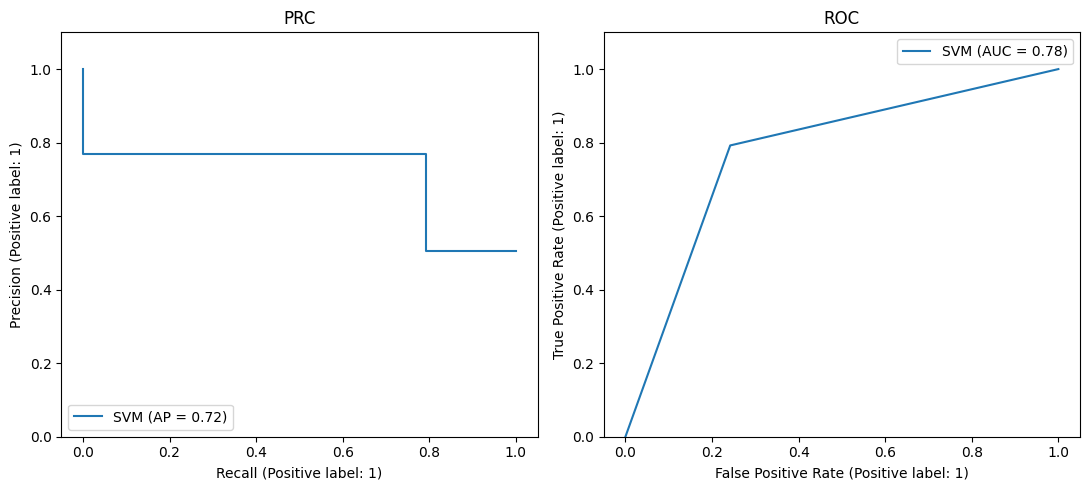

In [ ]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
depict_pr_roc(y_test, y_pred_svm, 'SVM')

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)
df_metrics.loc['SVM'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_svm),
      0
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVM,0.833686,0.775138,0.0


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
# у SVM они больше, то есть площадь под кривыми больше -> мы ближе к идеальному классификатору
# то есть SVM работает лучше монетки)

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression
for reg in [1000000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00000001]:
  lr = LogisticRegression(C = reg)
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  precision, recall, _ = precision_recall_curve(y_test, y_pred)
  print(f'For reg = {reg} auc_pr = {auc(recall, precision)}')

For reg = 1000000 auc_pr = 0.8311566029589885
For reg = 100 auc_pr = 0.8311566029589885
For reg = 10 auc_pr = 0.8311566029589885
For reg = 1 auc_pr = 0.8311566029589885
For reg = 0.1 auc_pr = 0.8311566029589885
For reg = 0.01 auc_pr = 0.8316720271036777
For reg = 0.001 auc_pr = 0.8285812919766036
For reg = 0.0001 auc_pr = 0.8156627446144237
For reg = 1e-08 auc_pr = 0.7528333333333334


In [ ]:
# лучшее значение при reg = 1 / lambda = 0.01

In [ ]:
reg = 0.01
lr = LogisticRegression(C = reg)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
print(f'For reg = {reg} auc_pr = {auc(recall, precision)}')

For reg = 0.01 auc_pr = 0.8316720271036777


LogReg metrics
AUC-PR: 0.83167
AUC-ROC: 0.77202


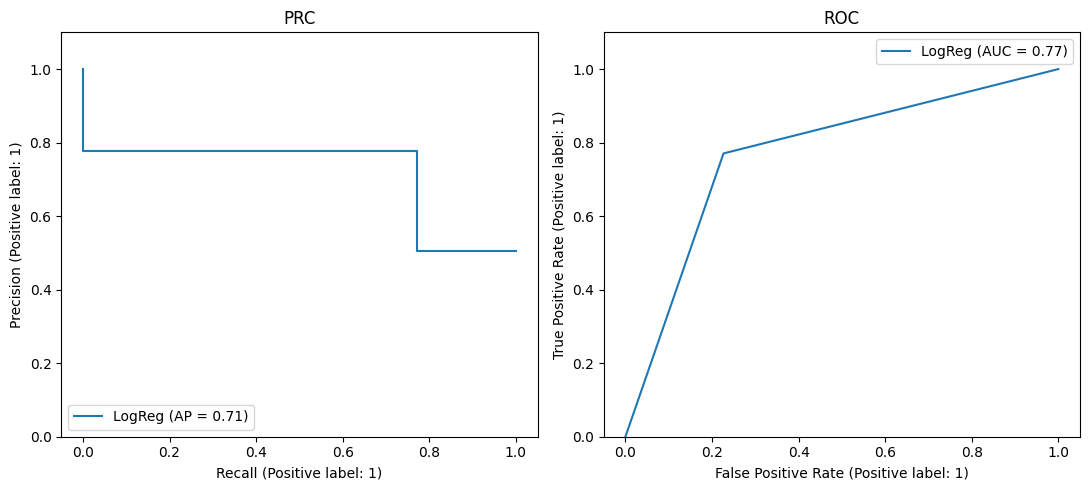

In [ ]:
depict_pr_roc(y_test, y_pred_lr, 'LogReg')

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
df_metrics.loc['LogReg'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_lr),
      0.01
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.00
SVM,0.833686,0.775138,0.00
LogReg,0.831672,0.772016,0.01


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


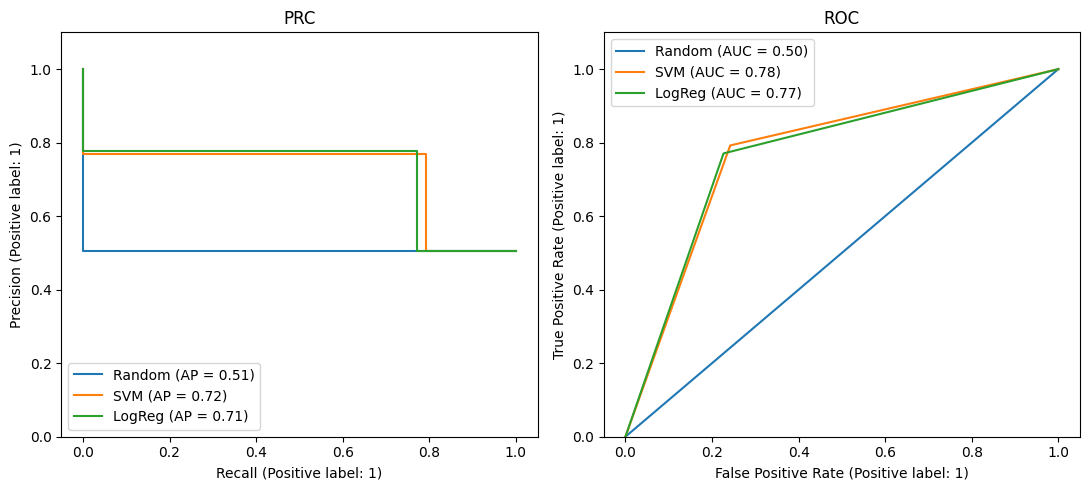

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

print('Random', 'metrics')
PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random')
PrecisionRecallDisplay.from_predictions(y_test, y_pred_svm, ax=ax[0], name='SVM')
PrecisionRecallDisplay.from_predictions(y_test, y_pred_lr, ax=ax[0], name='LogReg')
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random')
RocCurveDisplay.from_predictions(y_test, y_pred_svm, ax=ax[1], name='SVM')
RocCurveDisplay.from_predictions(y_test, y_pred_lr, ax=ax[1], name='LogReg')
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



In [ ]:
# Разницы почти нет, разделяющие поверхности находятся очень близко друг к другу
# Логрег чуть более осторожен и потому точен, в то же время у СВМ больше покрытие (recall)

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = SVC(kernel = 'linear')
model.fit(X, y)
# y_pred_svm = svm.predict(X_test)
# depict_pr_roc(y_test, y_pred_svm, 'SVM')

SVC(kernel='linear')

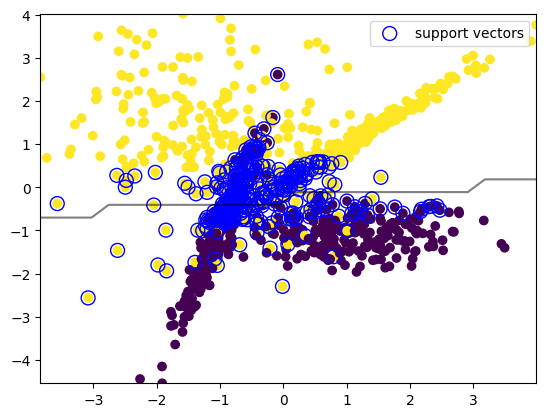

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.predict(np.c_[xy]).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])



    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



In [ ]:
# Либо с неправильным ответом ("на вражеской территории"),
# либо те, которые ближе прочих к разделяющей плоскости

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

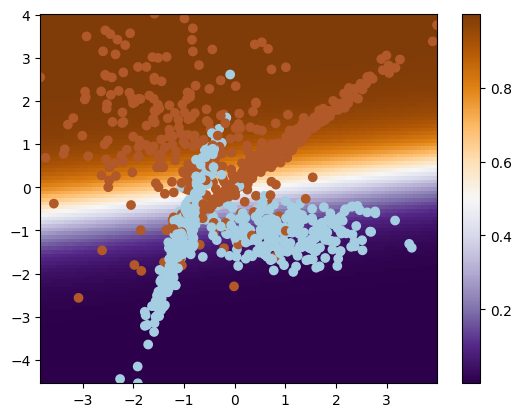

In [ ]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(np.c_[xy])[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


model = LogisticRegression()
model.fit(X, y)
plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



In [ ]:
# Белая полоса в центре
# Модель предсказывает 0.5, поскольку с точки
# зрения функции потерь это лучше, чем рискнуть
# и получить большой штраф за уверенность в неправильном
# ответе
# При этом объекты, которые находятся близко к "разделяющей поверхности",
# как раз и оказываются объектами, которые дают прогноз в районе 0.5

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

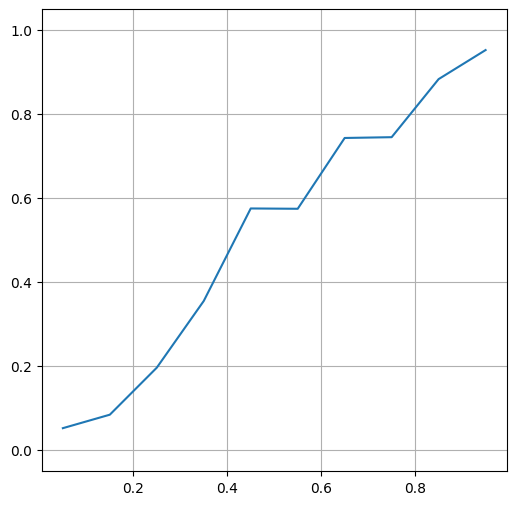

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 * i / n_bins
        r = 1.0 * (i + 1) / n_bins
        # bin_middle_points.append((l - r) / 2)
        bin_middle_points.append(l + (r - l) / 2) # средние точки должны сдвигаться вправо

        # bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / (y_test[(preds >= l) & (preds < r)]).shape)
        # Здесь нужно считать долю единичек на отрезке

    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

plot_calibration_curve(y, model.predict_proba(X)[:, 1])

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
# X, y = make_classification(
#     n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVC(kernel = 'linear', probability=True)
svm.fit(X_train, y_train)

reg = 0.01
lr = LogisticRegression(C = reg)
lr.fit(X_train, y_train)

# plot_calibration_curve(y_test, svm.predict_proba(X_test)[:, 1])
# plot_calibration_curve(y_test, lr.predict_proba(X_test)[:, 1])

LogisticRegression(C=0.01)

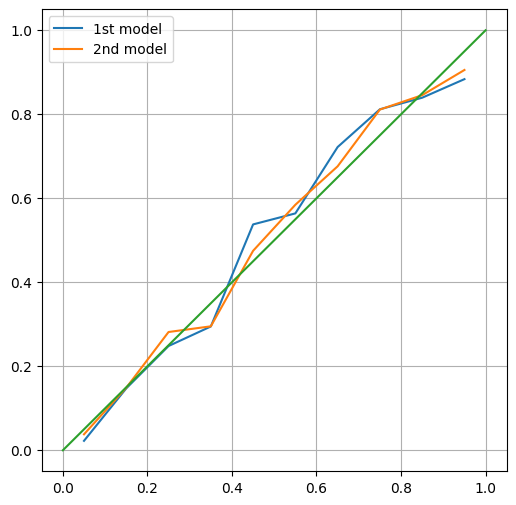

In [ ]:
def plot_calibration_curve(y_test, preds1, preds2):


    plt.figure(figsize=(6,6))
    # fig, ax = plt.subplots(1, 3, figsize=(11, 5))

    bin_middle_points1 = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 * i / n_bins
        r = 1.0 * (i + 1) / n_bins
        bin_middle_points1.append(l + (r - l) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds1 >= l) & (preds1 < r)] == 1) / (y_test[(preds1 >= l) & (preds1 < r)]).shape)

    ax[0] = plt.plot(bin_middle_points1, bin_real_ratios)


    bin_middle_points2 = []
    bin_real_ratios = []
    for i in range(n_bins):
        l = 1.0 * i / n_bins
        r = 1.0 * (i + 1) / n_bins
        bin_middle_points2.append(l + (r - l) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds2 >= l) & (preds2 < r)] == 1) / (y_test[(preds2 >= l) & (preds2 < r)]).shape)


    ax[1] = plt.plot(bin_middle_points2, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.legend(['1st model', '2nd model'])

    plt.plot([0, 1], [0, 1])

plot_calibration_curve(y_test, svm.predict_proba(X_test)[:, 1], lr.predict_proba(X_test)[:, 1])

In [ ]:
svm_noncal = svm.predict_proba(X_test)[:, 1]

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?


In [ ]:
# В целом норм, но можно и поэкстремальнее: обе модели немного недооценивают вероятность единички

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

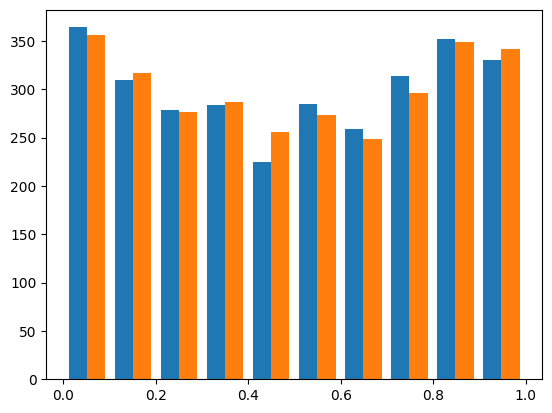

In [ ]:
plt.hist([svm.predict_proba(X_test)[:, 1], lr.predict_proba(X_test)[:, 1]]);

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

In [ ]:
# Практически нечем, небольшие различия вызваны тем, что эти модели решают одну и ту
# же задачу классификации, но разными путями

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
# X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, random_state=42, test_size = 0.3)

# svm.fit(X_train, y_train)
# calibrated_clf = CalibratedClassifierCV(svm, cv="prefit")
# calibrated_clf.fit(X_calib, y_calib)
# svm_cal = calibrated_clf.predict_proba(X_test)
# svm_cal = svm_cal[:, 1]

In [ ]:
# plot_calibration_curve(y_test, svm_noncal, svm_cal)

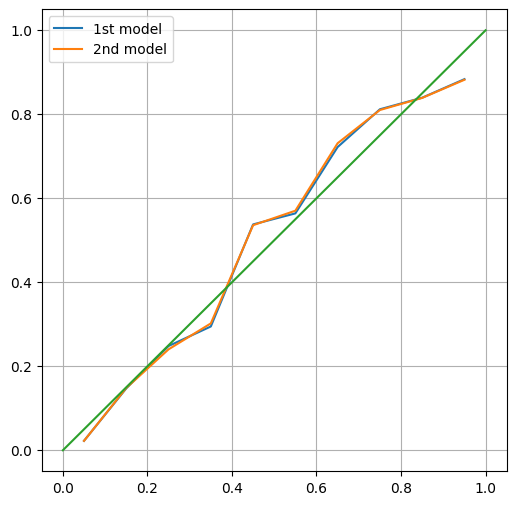

In [ ]:
calibrated_clf = CalibratedClassifierCV(svm, cv=3)
calibrated_clf.fit(X_train, y_train)

svm_cal = calibrated_clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, svm_noncal, svm_cal)

**Вопрос:** Улучшилась ли калибровочная кривая?

In [ ]:
# Практически не улучшилась(

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, svm_noncal)
print(f'SVM nc: AUC PR = {auc(recall, precision)}, AUC ROC = {roc_auc_score(y_test, svm_cal)}')

precision, recall, _ = precision_recall_curve(y_test, svm_cal)
print(f'SVM calibrated: AUC PR = {auc(recall, precision)}, AUC ROC = {roc_auc_score(y_test, svm_cal)}')

SVM nc: AUC PR = 0.8148942023631389, AUC ROC = 0.8478782385826447
SVM calibrated: AUC PR = 0.8143640854165549, AUC ROC = 0.8478782385826447


In [ ]:
# метрики, очевидно, тоже не поменялись

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
df = pd.read_csv('bike_buyers.csv')

X = df.drop(columns=['Purchased Bike', 'ID'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

cat = X.columns[X.dtypes == object].tolist()
num = X.columns[X.dtypes != object].tolist()

In [ ]:
X[cat] = X[cat].fillna('undefined')
X[cat].isna().sum()

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
dtype: int64

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
#Разделим на категориальные признаки и числовые
X_num_train, X_num_test = X_train[num], X_test[num]
X_train, X_test = X_train[cat], X_test[cat]

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
X_train

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,Married,Female,Bachelors,Clerical,Yes,0-1 Miles,Europe
540,Single,Female,Graduate Degree,Management,Yes,1-2 Miles,North America
110,Single,Female,Partial College,Manual,No,0-1 Miles,Europe
902,Single,Male,Bachelors,Skilled Manual,Yes,2-5 Miles,North America
15,Single,Female,High School,Manual,Yes,0-1 Miles,Europe
...,...,...,...,...,...,...,...
483,Married,Male,Graduate Degree,Clerical,Yes,0-1 Miles,Europe
375,Married,Female,Bachelors,Skilled Manual,Yes,0-1 Miles,Europe
968,Single,Male,Partial High School,Clerical,No,5-10 Miles,North America
756,Married,Male,Bachelors,Skilled Manual,No,0-1 Miles,North America


In [ ]:
import time
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
start_time = time.time()

ord_enc = OrdinalEncoder()
X_train_ord = ord_enc.fit_transform(X_train)
X_test_ord = ord_enc.transform(X_test)
print(ord_enc.categories_)

lr = LogisticRegression()
lr.fit(X_train_ord, y_train)
y_pred = lr.predict(X_test_ord)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

end_time = time.time()

ord_enc_time = end_time - start_time
print('ord_enc_time: ', ord_enc_time)


[array(['Married', 'Single', 'undefined'], dtype=object), array(['Female', 'Male', 'undefined'], dtype=object), array(['Bachelors', 'Graduate Degree', 'High School', 'Partial College',
       'Partial High School'], dtype=object), array(['Clerical', 'Management', 'Manual', 'Professional',
       'Skilled Manual'], dtype=object), array(['No', 'Yes', 'undefined'], dtype=object), array(['0-1 Miles', '1-2 Miles', '10+ Miles', '2-5 Miles', '5-10 Miles'],
      dtype=object), array(['Europe', 'North America', 'Pacific'], dtype=object)]
AUC_PR = 0.6261569579288027
ord_enc_time:  0.02080392837524414


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
start_time = time.time()

ohe_enc = OneHotEncoder()
X_train_ohe = ohe_enc.fit_transform(X_train)
X_test_ohe = ohe_enc.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict(X_test_ohe)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

end_time = time.time()

ohe_enc_time = end_time - start_time
print('ohe_enc_time: ', ohe_enc_time)


AUC_PR = 0.7048893557422969
ohe_enc_time:  0.04000544548034668


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dic = dict()

    def fit(self, X, y):
        for col in X.columns:
          means = y_train.groupby(X_train[col]).agg(['mean'])
          self.dic[col] = means
        # Здесь запоминаем средние
        return self

    def transform(self, Xt):
        X = Xt.copy()
        for col in self.dic.keys():
          for val in self.dic[col].index:
            X = X.replace(val, self.dic[col].loc[self.dic[col].index == val, 'mean'][0])
        return X

In [ ]:
X_train

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,Married,Female,Bachelors,Clerical,Yes,0-1 Miles,Europe
540,Single,Female,Graduate Degree,Management,Yes,1-2 Miles,North America
110,Single,Female,Partial College,Manual,No,0-1 Miles,Europe
902,Single,Male,Bachelors,Skilled Manual,Yes,2-5 Miles,North America
15,Single,Female,High School,Manual,Yes,0-1 Miles,Europe
...,...,...,...,...,...,...,...
483,Married,Male,Graduate Degree,Clerical,Yes,0-1 Miles,Europe
375,Married,Female,Bachelors,Skilled Manual,Yes,0-1 Miles,Europe
968,Single,Male,Partial High School,Clerical,No,5-10 Miles,North America
756,Married,Male,Bachelors,Skilled Manual,No,0-1 Miles,North America


In [ ]:
start_time = time.time()

trg_enc = TargetEncoder()
trg_enc.fit(X_train, y_train)
X_train_trg = trg_enc.transform(X_train)
X_test_trg = trg_enc.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_trg, y_train)
y_pred = lr.predict(X_test_trg)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

end_time = time.time()

trg_enc_time = end_time - start_time
print('trg_enc_time: ', trg_enc_time)


AUC_PR = 0.6592056737588652
trg_enc_time:  0.07458710670471191


In [ ]:
# Таргет-енк сильно дольше, а AUC даже меньше, чем у OHE

In [ ]:
X_train_trg

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079
110,0.552632,0.504155,0.437186,0.482759,0.489270,0.535581,0.488372
902,0.552632,0.463158,0.529915,0.478947,0.478599,0.566667,0.430079
15,0.552632,0.504155,0.466165,0.482759,0.478599,0.535581,0.488372
...,...,...,...,...,...,...,...
483,0.415423,0.463158,0.543307,0.484848,0.478599,0.535581,0.488372
375,0.415423,0.504155,0.529915,0.478947,0.478599,0.535581,0.488372
968,0.552632,0.463158,0.333333,0.484848,0.489270,0.437086,0.430079
756,0.415423,0.463158,0.529915,0.478947,0.489270,0.535581,0.430079


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dic = dict()

    def fit(self, X, y):
        for col in X.columns:
          means = y_train.groupby(X_train[col]).agg(['mean'])
          self.dic[col] = means
        # Здесь запоминаем средние
        return self

    def transform(self, X):
        for col in self.dic.keys():
          for val in self.dic[col].index:
            X = X.replace(val, self.dic[col].loc[self.dic[col].index == val, 'mean'][0])
        er = np.random.normal(0, y_train.var()/10, size=(len(X), len(self.dic.keys())))
        # er = np.random.normal(0, 0.1, size=(len(X), len(self.dic.keys())))
        return X + er

In [ ]:
start_time = time.time()

trg_enc = TargetEncoder()
trg_enc.fit(X_train, y_train)
X_train_trg = trg_enc.transform(X_train)
X_test_trg = trg_enc.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_trg, y_train)
y_pred = lr.predict(X_test_trg)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

end_time = time.time()

trg_enc_time = end_time - start_time
print('trg_enc_time: ', trg_enc_time)
X_train_trg

AUC_PR = 0.6543163265306122
trg_enc_time:  0.07173013687133789


,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,0.405993,0.482332,0.575846,0.458860,0.477188,0.554883,0.469111
540,0.536015,0.551486,0.565996,0.446454,0.437257,0.486294,0.370638
110,0.536074,0.507201,0.442652,0.486593,0.468589,0.511701,0.474909
902,0.550016,0.453668,0.528391,0.421372,0.486088,0.544626,0.441149
15,0.533719,0.475030,0.466325,0.517871,0.471477,0.534304,0.462671
...,...,...,...,...,...,...,...
483,0.454433,0.438933,0.488355,0.471314,0.425586,0.538955,0.490160
375,0.379275,0.508096,0.560957,0.466333,0.513679,0.551238,0.492874
968,0.561662,0.457381,0.348785,0.524493,0.484064,0.485540,0.407653
756,0.392945,0.506318,0.540052,0.470389,0.477226,0.563124,0.413305


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

In [ ]:
# Шум сделал реализацию еще медленнее, но зато AUC сильно подрос
# Рост метрики вызван тем, что мы боремся с переобучением

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, c):
        self.dic = dict()
        self.c = c

    def fit(self, X, y):
        for col in X.columns:
          sums = y.groupby(X[col]).agg(['sum'])
          counts = y.groupby(X[col]).agg(['count'])
          # sums = y_train.groupby(X_train[col]).agg(['sum'])
          # counts = y_train.groupby(X_train[col]).agg(['count'])
          self.dic[col] = [sums, counts]
          self.ymean = y.mean()
        # Здесь запоминаем средние
        return self

    def transform(self, X):
        for col in self.dic.keys():
          for val in self.dic[col][0].index:
            numm = self.dic[col][0].loc[self.dic[col][0].index == val, 'sum'][0] + self.c * self.ymean
            denum = self.dic[col][1].loc[self.dic[col][1].index == val, 'count'][0] + self.c
            X = X.replace(val, numm / denum)
        er = np.random.normal(0, y_train.var()/20, size=(len(X), len(self.dic.keys())))
        return X + er

In [ ]:
np.random.seed(seed)
start_time = time.time()

trg_enc = TargetEncoder(-7)
trg_enc.fit(X_train, y_train)
X_train_trg = trg_enc.transform(X_train)
X_test_trg = trg_enc.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_trg, y_train)
y_pred = lr.predict(X_test_trg)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

end_time = time.time()

trg_enc_time = end_time - start_time
print('trg_enc_time: ', trg_enc_time)
X_train_trg

AUC_PR = 0.7079926253687315
trg_enc_time:  0.09369397163391113


,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,0.405793,0.498166,0.517650,0.483620,0.466994,0.514394,0.496111
540,0.556617,0.514644,0.546179,0.435040,0.473200,0.468435,0.411816
110,0.538272,0.514240,0.433857,0.483005,0.485550,0.522915,0.518993
902,0.566959,0.459820,0.536166,0.470781,0.458510,0.570784,0.422146
15,0.554316,0.499073,0.483705,0.469434,0.473043,0.529573,0.501765
...,...,...,...,...,...,...,...
483,0.423161,0.456647,0.546294,0.481968,0.487219,0.558443,0.485175
375,0.414901,0.513490,0.524999,0.463219,0.476314,0.538721,0.492862
968,0.540939,0.463969,0.313292,0.490442,0.492268,0.429247,0.403100
756,0.409375,0.481824,0.548489,0.493260,0.473156,0.532167,0.432640


In [ ]:
# OHE = 0.7048893557422969
# TRG (-7) = 0.7079926253687315

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

X_num_train = pd.DataFrame(imp_mean.fit_transform(X_num_train), columns = imp_mean.get_feature_names_out())
X_num_test = pd.DataFrame(imp_mean.transform(X_num_test), columns = imp_mean.get_feature_names_out())
X_num_train

,Income,Children,Cars,Age
0,20000.000000,1.0,0.0,50.0
1,70000.000000,3.0,2.0,52.0
2,56120.805369,1.0,0.0,46.0
3,80000.000000,3.0,0.0,40.0
4,10000.000000,2.0,1.0,38.0
...,...,...,...,...
745,10000.000000,1.0,0.0,70.0
746,40000.000000,1.0,1.0,89.0
747,30000.000000,0.0,2.0,27.0
748,40000.000000,1.0,1.0,36.0


In [ ]:
np.random.seed(seed)
start_time = time.time()

lr = LogisticRegression()
lr.fit(X_num_train, y_train)
y_pred = lr.predict(X_num_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

end_time = time.time()

num_time = end_time - start_time
print('numerical features time: ', num_time)
X_train_trg

AUC_PR = 0.5923333333333334
numerical features time:  0.012855291366577148


,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,0.405793,0.498166,0.517650,0.483620,0.466994,0.514394,0.496111
540,0.556617,0.514644,0.546179,0.435040,0.473200,0.468435,0.411816
110,0.538272,0.514240,0.433857,0.483005,0.485550,0.522915,0.518993
902,0.566959,0.459820,0.536166,0.470781,0.458510,0.570784,0.422146
15,0.554316,0.499073,0.483705,0.469434,0.473043,0.529573,0.501765
...,...,...,...,...,...,...,...
483,0.423161,0.456647,0.546294,0.481968,0.487219,0.558443,0.485175
375,0.414901,0.513490,0.524999,0.463219,0.476314,0.538721,0.492862
968,0.540939,0.463969,0.313292,0.490442,0.492268,0.429247,0.403100
756,0.409375,0.481824,0.548489,0.493260,0.473156,0.532167,0.432640


In [ ]:
# негусто(

In [ ]:
X_train = pd.concat([X_train_trg.reset_index(), X_num_train.reset_index()], axis=1)
X_test = pd.concat([X_test_trg.reset_index(), X_num_test.reset_index()], axis=1)

In [ ]:
X_train.shape

(750, 13)

In [ ]:
X_train

,index,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,index,Income,Children,Cars,Age
0,345,0.405793,0.498166,0.517650,0.483620,0.466994,0.514394,0.496111,0,20000.000000,1.0,0.0,50.0
1,540,0.556617,0.514644,0.546179,0.435040,0.473200,0.468435,0.411816,1,70000.000000,3.0,2.0,52.0
2,110,0.538272,0.514240,0.433857,0.483005,0.485550,0.522915,0.518993,2,56120.805369,1.0,0.0,46.0
3,902,0.566959,0.459820,0.536166,0.470781,0.458510,0.570784,0.422146,3,80000.000000,3.0,0.0,40.0
4,15,0.554316,0.499073,0.483705,0.469434,0.473043,0.529573,0.501765,4,10000.000000,2.0,1.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,483,0.423161,0.456647,0.546294,0.481968,0.487219,0.558443,0.485175,745,10000.000000,1.0,0.0,70.0
746,375,0.414901,0.513490,0.524999,0.463219,0.476314,0.538721,0.492862,746,40000.000000,1.0,1.0,89.0
747,968,0.540939,0.463969,0.313292,0.490442,0.492268,0.429247,0.403100,747,30000.000000,0.0,2.0,27.0
748,756,0.409375,0.481824,0.548489,0.493260,0.473156,0.532167,0.432640,748,40000.000000,1.0,1.0,36.0


In [ ]:
np.random.seed(seed)
start_time = time.time()

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

end_time = time.time()

all_time = end_time - start_time
print('whole X time: ', all_time)
X_train_trg

AUC_PR = 0.6801666666666666
whole X time:  0.03591299057006836


,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,0.405793,0.498166,0.517650,0.483620,0.466994,0.514394,0.496111
540,0.556617,0.514644,0.546179,0.435040,0.473200,0.468435,0.411816
110,0.538272,0.514240,0.433857,0.483005,0.485550,0.522915,0.518993
902,0.566959,0.459820,0.536166,0.470781,0.458510,0.570784,0.422146
15,0.554316,0.499073,0.483705,0.469434,0.473043,0.529573,0.501765
...,...,...,...,...,...,...,...
483,0.423161,0.456647,0.546294,0.481968,0.487219,0.558443,0.485175
375,0.414901,0.513490,0.524999,0.463219,0.476314,0.538721,0.492862
968,0.540939,0.463969,0.313292,0.490442,0.492268,0.429247,0.403100
756,0.409375,0.481824,0.548489,0.493260,0.473156,0.532167,0.432640




Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

In [ ]:
# Счетчики гибче - там много прикольных методов с гиперпараметрами,
# то есть в теории с их помощью можно выбить качество лучше охе (если постараться)
# При этом базисно охе проще, тк там не нужно подбирать параметры + он быстрее

# Часть 3. Отбор признаков (2 балла)

#### Подготовка####
Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-26 19:24:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [  <=>               ]   3.79M  9.46MB/s    in 0.4s    

2023-11-26 19:24:30 (9.46 MB/s) - ‘adult.data’ saved [3974305]



In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
29325,20,?,133515,Some-college,10,Never-married,?,Own-child,White,Female,0,0,15,France,0


#### Подготовка ####

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
X = df.drop(columns = ['income'])
y = df['income']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
print(X_train.shape)
np.unique(list(X_train.dtypes), return_counts=True)

(24420, 14)


(array([dtype('int64'), dtype('O')], dtype=object), array([6, 8]))

In [ ]:
ohe_enc = OneHotEncoder()
X_num_train = X_train[X.columns[X.dtypes != object].tolist()]
X_num_test = X_test[X.columns[X.dtypes != object].tolist()]
X_train_cat = ohe_enc.fit_transform(X_train[X.columns[X.dtypes == object].tolist()])
X_test_cat = ohe_enc.transform(X_test[X.columns[X.dtypes == object].tolist()])

In [ ]:
X_train_cat

<24420x102 sparse matrix of type '<class 'numpy.float64'>'
	with 195360 stored elements in Compressed Sparse Row format>

In [ ]:
X_num_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
14004,60,194252,14,3103,0,40
21060,41,26669,10,0,0,40
7926,18,165754,10,0,0,30
11552,61,115023,9,0,0,40
15648,26,93806,10,0,0,55
...,...,...,...,...,...,...
18970,20,94744,9,0,0,20
21382,62,41793,14,0,0,50
10830,47,152073,9,0,0,40
14560,33,222221,9,7298,0,45


In [ ]:
print(X_train.shape, X_test.shape)

(24420, 14) (8141, 14)


In [ ]:
X_train = pd.concat([X_num_train.reset_index(), pd.DataFrame(X_train_cat.toarray()).reset_index()], axis=1).drop(columns = ['index'])

In [ ]:
X_test = pd.concat([X_num_test.reset_index(), pd.DataFrame(X_test_cat.toarray()).reset_index()], axis=1).drop(columns = ['index'])

In [ ]:
X_test.shape

(8141, 108)

In [ ]:
# У нас было 8 категориальных признаков, а стало 102 :'(

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
np.random.seed(seed)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'OHE: AUC_PR = {auc(recall, precision)}')

OHE: AUC_PR = 0.5682073185072054


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
np.random.seed(seed)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

AUC_PR = 0.5682073185072054


<Axes: ylabel='Feature'>

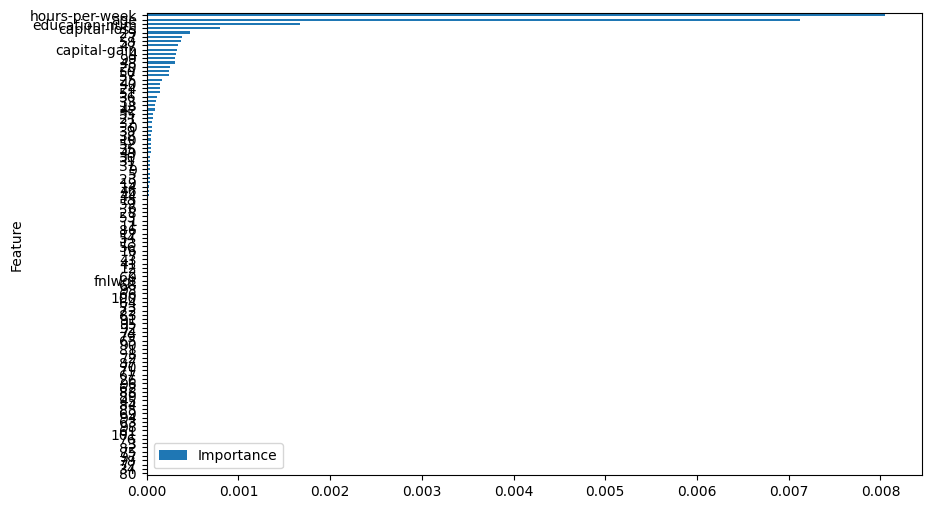

In [ ]:
coefs = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefs)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
cool = (feature_importance.sort_values('Importance', ascending=False)[:40]).iloc[:, 0].tolist()

In [ ]:
np.random.seed(seed)
lr = LogisticRegression(max_iter=200)
lr.fit(X_train[cool], y_train)
y_pred = lr.predict(X_test[cool])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'Best 40: AUC_PR = {auc(recall, precision)}')

Best 40: AUC_PR = 0.6975164483156051


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Изменилось ли качество? Как?

In [ ]:
# Качество выросло хахахахахах

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

np.random.seed(seed)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC_PR = {auc(recall, precision)}')

AUC_PR = 0.7184708034481659


In [ ]:
# Стандартизация увеличила AUC PR с 0.56 до 0.71, неплохо

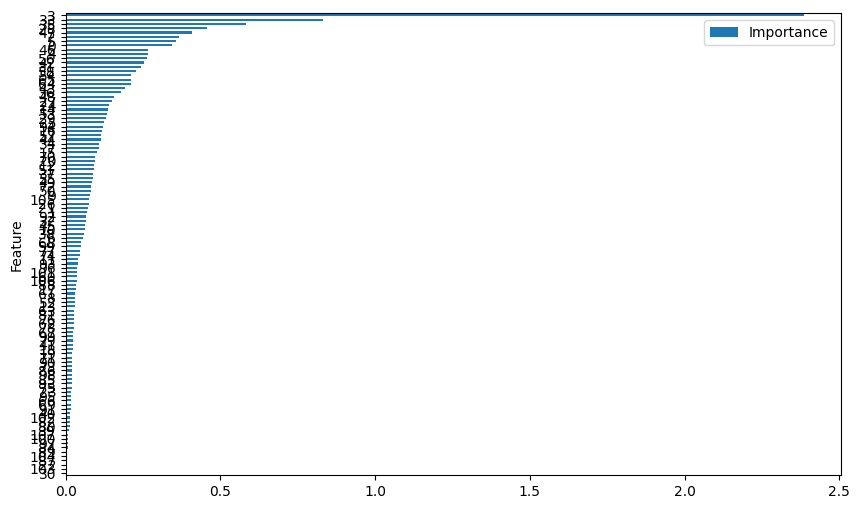

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

coefs = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefs)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

cool = (feature_importance.sort_values('Importance', ascending=False)[:40]).iloc[:, 0].tolist()

In [ ]:
np.random.seed(seed)
lr = LogisticRegression(max_iter=200)
lr.fit(X_train[cool], y_train)
y_pred = lr.predict(X_test[cool])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'Best 40: AUC_PR = {auc(recall, precision)}')

Best 40: AUC_PR = 0.7151164585671379


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
# Ребята, я прям конкретно засыпался.
# Сначала я сделал все как норм чел: стандартизировал все признаки,
# порадовался улучшению аука с 56 до 71 и загрустил от того, что отбор 40 только ухудшил результат,
# пусть и на сотые доли

# Но отбор 40 лучших признаков без стандартизации сработал на ура: аук вырос
# с 56 практически до 70, то есть все хорошо и без скалирования.

# waaaaat

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
X_train_cat = pd.DataFrame(X_train_cat.toarray())

In [ ]:
t_stats = pd.DataFrame(columns = ['feature', 't-stat'])
for feature in X_train_cat.columns:
  numm = (y_train[(X_train_cat[feature] == 1).tolist()]).sum() / len(y_train)
  a = (X_train_cat[feature] == 1).sum() * y_train[(X_train_cat[feature] == 1).tolist()].var()
  b = (X_train_cat[feature] == 0).sum() * y_train[(X_train_cat[feature] == 0).tolist()].var()
  denum = np.sqrt((a + b) / len(y_train))
  t = numm / denum
  if feature < 5:
    print(feature, t)
  tt = {'feature': [feature], 't-stat': [t]}
  tt = pd.DataFrame(tt)
  t_stats = pd.concat([t_stats, tt], ignore_index = True)
  t_stats.reset_index()
pd.DataFrame(t_stats)

0 0.0145006428918637
1 0.027539938843398743
2 0.04330489130026269
3 0.0
4 0.35749144736192195


,feature,t-stat
0,0,0.014501
1,1,0.027540
2,2,0.043305
3,3,0.000000
4,4,0.357491
...,...,...
97,97,0.000287
98,98,0.000192
99,99,0.516031
100,100,0.000479


In [ ]:
cool = (t_stats.sort_values('t-stat', ascending=False)[:40])
cool

,feature,t-stat
27,27,0.536252
99,99,0.516031
57,57,0.513021
59,59,0.490270
47,47,0.463602
4,4,0.357491
18,18,0.158422
36,36,0.143390
42,42,0.135587
20,20,0.124066


In [ ]:
cool = cool.iloc[:, 0].tolist()

In [ ]:
np.random.seed(seed)
lr = LogisticRegression(max_iter=200)
lr.fit(X_train[cool], y_train)
y_pred = lr.predict(X_test[cool])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'Best 40: AUC_PR = {auc(recall, precision)}')

Best 40: AUC_PR = 0.6861834991225285


In [ ]:
# Метод крутой, но сработал хуже

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [ ]:
# for bad in X_train.columns:
#   np.random.seed(seed)
#   good = list(X_train.columns)
#   print(good)
#   good.remove(bad)
#   print(good)
#   lr = LogisticRegression(max_iter=100)
#   lr.fit(X_train[good], y_train)
#   y_pred = lr.predict(X_val[good])
#   precision, recall, _ = precision_recall_curve(y_val, y_pred)
#   au = auc(recall, precision)

#   tt = {'Dropped feature': [bad], 'AUC': [au]}
#   tt = pd.DataFrame(tt)
#   stats = pd.concat([stats, tt], ignore_index = True)
#   print(stats)
#   stats.reset_index()
#   break
# pd.DataFrame(stats)

In [ ]:
while X_train.columns.shape[0] > 40:
  break # Для проверки убрать эту строчку
  stats = pd.DataFrame(columns = ['Dropped feature', 'AUC'])
  for bad in X_train.columns:
    np.random.seed(seed)
    good = list(X_train.columns)
    good.remove(bad)
    lr = LogisticRegression(max_iter=100)
    lr.fit(X_train[good], y_train)
    y_pred = lr.predict(X_val[good])
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    au = auc(recall, precision)

    tt = {'Dropped feature': [bad], 'AUC': [au]}
    tt = pd.DataFrame(tt)
    stats = pd.concat([stats, tt], ignore_index = True)
    stats.reset_index()
  pd.DataFrame(stats)
  X_train = X_train[(stats.sort_values('AUC', ascending=True)[:-1])['Dropped feature']]
  X_val = X_val[(stats.sort_values('AUC', ascending=True)[:-1])['Dropped feature']]
  X_test = X_test[(stats.sort_values('AUC', ascending=True)[:-1])['Dropped feature']]


  # Я точно не проверял, но эта штука должна работать минут 15-20))))

  # Пока у нас не осталось ровно 40 признаков,
  #   для каждого признака обучим логрег и выкинем тот, у которого
  #   AUС будет самым высоким (значит мы и без него справились)

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
while X_train.columns.shape[0] < 40:
  break # убрать эту строчку для проверки
  feats = []
  stats = pd.DataFrame(columns = ['Dropped feature', 'AUC'])
  for bad in X_train.columns:
    np.random.seed(seed)
    good = feats.copy() # Берем накопленные признаки
    good.append(bad) # и добавляем один (по которому итерируемся)
    lr = LogisticRegression(max_iter=100)
    lr.fit(X_train[good], y_train)
    y_pred = lr.predict(X_val[good])
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    au = auc(recall, precision)

    tt = {'Dropped feature': [bad], 'AUC': [au]}
    tt = pd.DataFrame(tt)
    stats = pd.concat([stats, tt], ignore_index = True)
    stats.reset_index()
  pd.DataFrame(stats)
  X_train = X_train[(stats.sort_values('AUC', ascending=False)[:-1])['Dropped feature']]
  X_val = X_val[(stats.sort_values('AUC', ascending=False)[:-1])['Dropped feature']]
  X_test = X_test[(stats.sort_values('AUC', ascending=False)[:-1])['Dropped feature']]


  # тут похожая логика и это тоже долго

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?



In [ ]:
# Лучшим оказался метод с отбором признаков при помощи логрега,
# самым элегантным - с т-статистикой
# самым долгим и потому неприменимым - метод с перебором

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-26 19:24:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.76MB/s    in 0.2s    

2023-11-26 19:24:36 (1.76 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=500)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=5, random_state=500, shuffle=True)


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
preds = dict()
trues = dict()
for i, (train_index, test_index) in enumerate(kf.split(X)):
  lr = LogisticRegression(max_iter=300)

  X_train = X.loc[train_index]
  X_test = X.loc[test_index]

  ohe_enc = OneHotEncoder()
  X_num_train = X_train[X.columns[X.dtypes != object].tolist()]
  X_num_test = X_test[X.columns[X.dtypes != object].tolist()]
  X_train_cat = ohe_enc.fit_transform(X_train[X.columns[X.dtypes == object].tolist()])
  X_test_cat = ohe_enc.transform(X_test[X.columns[X.dtypes == object].tolist()])

  X_train = pd.concat([X_num_train.reset_index(), pd.DataFrame(X_train_cat.toarray()).reset_index()], axis=1).drop(columns = ['index'])
  X_test = pd.concat([X_num_test.reset_index(), pd.DataFrame(X_test_cat.toarray()).reset_index()], axis=1).drop(columns = ['index'])

  X_train.columns = X_train.columns.astype(str)
  X_test.columns = X_test.columns.astype(str)

  lr.fit(X_train, y.loc[train_index])
  y_pred = lr.predict(X_test)
  precision, recall, _ = precision_recall_curve(y.loc[test_index], y_pred)
  au = auc(recall, precision)
  print(f"Fold {i}: {au}")
  print(y_pred.shape,  y.loc[test_index].shape)
  preds[i] = y_pred
  trues[i] = y.loc[test_index]

Fold 0: 0.5288603835108466
(8238,) (8238,)
Fold 1: 0.4838277865760565
(8238,) (8238,)
Fold 2: 0.4882903869784877
(8238,) (8238,)
Fold 3: 0.4964891236071798
(8237,) (8237,)
Fold 4: 0.47030555714366173
(8237,) (8237,)


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
# Profit = yes - 10 * calls

rr = []
cc = []
pp = []

from sklearn.metrics import precision_score
for i in range(5):
  pr = precision_score(trues[i], preds[i])
  print('Количество срабатываний алгоритма =', len(trues[i]))
  print('Количество утилизаций =', int(len(trues[i]) * pr))
  print('Точность =', pr)


  r = 10 * int(len(trues[i]) * pr)
  c = len(trues[i])
  p = 10 * int(len(trues[i]) * pr) - len(trues[i])



  print('Выручка =', r)
  print('Затраты =', c)
  print('Прибыль =', p)

  rr.append(r)
  cc.append(c)
  pp.append(p)

  print('')

print('Средняя выручка =', np.array(rr).mean()) # Столько заработаю
print('Средние затраты =', np.array(cc).mean()) # Столько отдам операторам
print('Средняя прибыль =', np.array(pp).mean()) # Столько останется

print('Стандартное отклонение =', np.array(rr).std())

Количество срабатываний алгоритма = 8238
Количество утилизаций = 6080
Точность = 0.7380952380952381
Выручка = 60800
Затраты = 8238
Прибыль = 52562

Количество срабатываний алгоритма = 8238
Количество утилизаций = 5299
Точность = 0.6432748538011696
Выручка = 52990
Затраты = 8238
Прибыль = 44752

Количество срабатываний алгоритма = 8238
Количество утилизаций = 5425
Точность = 0.6585365853658537
Выручка = 54250
Затраты = 8238
Прибыль = 46012

Количество срабатываний алгоритма = 8237
Количество утилизаций = 5562
Точность = 0.6753246753246753
Выручка = 55620
Затраты = 8237
Прибыль = 47383

Количество срабатываний алгоритма = 8237
Количество утилизаций = 5272
Точность = 0.6401273885350318
Выручка = 52720
Затраты = 8237
Прибыль = 44483

Средняя выручка = 55276.0
Средние затраты = 8237.6
Средняя прибыль = 47038.4
Стандартное отклонение = 2947.6946924673184


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
# Profit = yes - 10 * calls

rr = []
cc = []
pp = []

from sklearn.metrics import precision_score
for i in range(5):
  # np.random.seed(i)
  pr = precision_score(trues[i], preds[i])
  print('Количество срабатываний алгоритма =', len(trues[i]))
  print('Количество утилизаций =', int(len(trues[i]) * pr))
  print('Точность =', pr)

  m = np.random.uniform(0, 20, int(len(trues[i]) * pr))

  r = np.sum(m)
  c = len(trues[i])
  p = np.sum(m)



  print('Выручка =', r)
  print('Затраты =', c)
  print('Прибыль =', p)

  rr.append(r)
  cc.append(c)
  pp.append(p)

  print('')

print('Средняя выручка =', np.array(rr).mean()) # Столько заработаю
print('Средние затраты =', np.array(cc).mean()) # Столько отдам операторам
print('Средняя прибыль =', np.array(pp).mean()) # Столько останется
print('Стандартное отклонение =', np.array(pp).std())

Количество срабатываний алгоритма = 8238
Количество утилизаций = 6080
Точность = 0.7380952380952381
Выручка = 61493.35062013102
Затраты = 8238
Прибыль = 61493.35062013102

Количество срабатываний алгоритма = 8238
Количество утилизаций = 5299
Точность = 0.6432748538011696
Выручка = 53440.62254150506
Затраты = 8238
Прибыль = 53440.62254150506

Количество срабатываний алгоритма = 8238
Количество утилизаций = 5425
Точность = 0.6585365853658537
Выручка = 54154.8041046036
Затраты = 8238
Прибыль = 54154.8041046036

Количество срабатываний алгоритма = 8237
Количество утилизаций = 5562
Точность = 0.6753246753246753
Выручка = 55167.14906986465
Затраты = 8237
Прибыль = 55167.14906986465

Количество срабатываний алгоритма = 8237
Количество утилизаций = 5272
Точность = 0.6401273885350318
Выручка = 52184.13406971957
Затраты = 8237
Прибыль = 52184.13406971957

Средняя выручка = 55288.01208116479
Средние затраты = 8237.6
Средняя прибыль = 55288.01208116479
Стандартное отклонение = 3251.212124423731


In [ ]:
# Средние отличаются на доли процента, стандартные отклонения тоже не оч сильно
# Причина в том, что матожидание такое же, поэтому при большом количестве
# клиентов мы получваем примерно по 10 с каждого

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=500)
kf.get_n_splits(X)
print(kf)

preds = dict()
trues = dict()
for i, (train_index, test_index) in enumerate(kf.split(X)):
  lr = LogisticRegression(max_iter=300, C = 1)

  X_train = X.loc[train_index]
  X_test = X.loc[test_index]

  ohe_enc = OneHotEncoder()
  X_num_train = X_train[X.columns[X.dtypes != object].tolist()]
  X_num_test = X_test[X.columns[X.dtypes != object].tolist()]
  X_train_cat = ohe_enc.fit_transform(X_train[X.columns[X.dtypes == object].tolist()])
  X_test_cat = ohe_enc.transform(X_test[X.columns[X.dtypes == object].tolist()])

  X_train = pd.concat([X_num_train.reset_index(), pd.DataFrame(X_train_cat.toarray()).reset_index()], axis=1).drop(columns = ['index'])
  X_test = pd.concat([X_num_test.reset_index(), pd.DataFrame(X_test_cat.toarray()).reset_index()], axis=1).drop(columns = ['index'])

  X_train.columns = X_train.columns.astype(str)
  X_test.columns = X_test.columns.astype(str)

  lr.fit(X_train, y.loc[train_index])
  y_pred = lr.predict(X_test)
  precision, recall, _ = precision_recall_curve(y.loc[test_index], y_pred)
  au = auc(recall, precision)
  print(f"Fold {i}: {au}")
  print(y_pred.shape,  y.loc[test_index].shape)
  preds[i] = y_pred
  trues[i] = y.loc[test_index]



# Profit = yes - 10 * calls

rr = []
cc = []
pp = []

from sklearn.metrics import precision_score
for i in range(5):
  # np.random.seed(i)
  pr = precision_score(trues[i], preds[i])
  print('Количество срабатываний алгоритма =', len(trues[i]))
  print('Количество утилизаций =', int(len(trues[i]) * pr))
  print('Точность =', pr)

  m = np.random.uniform(0, 20, int(len(trues[i]) * pr))

  r = np.sum(m)
  c = len(trues[i])
  p = np.sum(m)



  print('Выручка =', r)
  print('Затраты =', c)
  print('Прибыль =', p)

  rr.append(r)
  cc.append(c)
  pp.append(p)

  print('')

print('Средняя выручка =', np.array(rr).mean()) # Столько заработаю
print('Средние затраты =', np.array(cc).mean()) # Столько отдам операторам
print('Средняя прибыль =', np.array(pp).mean()) # Столько останется
print('Стандартное отклонение =', np.array(pp).std())

KFold(n_splits=5, random_state=500, shuffle=True)
Fold 0: 0.5288603835108466
(8238,) (8238,)
Fold 1: 0.4838277865760565
(8238,) (8238,)
Fold 2: 0.4882903869784877
(8238,) (8238,)
Fold 3: 0.4964891236071798
(8237,) (8237,)
Fold 4: 0.47030555714366173
(8237,) (8237,)
Количество срабатываний алгоритма = 8238
Количество утилизаций = 6080
Точность = 0.7380952380952381
Выручка = 61335.48131165199
Затраты = 8238
Прибыль = 61335.48131165199

Количество срабатываний алгоритма = 8238
Количество утилизаций = 5299
Точность = 0.6432748538011696
Выручка = 52454.72371223911
Затраты = 8238
Прибыль = 52454.72371223911

Количество срабатываний алгоритма = 8238
Количество утилизаций = 5425
Точность = 0.6585365853658537
Выручка = 54028.54247536357
Затраты = 8238
Прибыль = 54028.54247536357

Количество срабатываний алгоритма = 8237
Количество утилизаций = 5562
Точность = 0.6753246753246753
Выручка = 55267.26189574154
Затраты = 8237
Прибыль = 55267.26189574154

Количество срабатываний алгоритма = 8237
Колич

In [ ]:
# Повышение качества => рост прибыли, неудивительно

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?



In [ ]:
# Свои слезы(